# Import libs

In [1]:
# Import some stuff
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
from dateutil.parser import parse
import pandas as pd


from pandas.io.json import json_normalize
from PIL import Image


#need to translate from wgs to bng to do spatial clustering
import pyproj

In [2]:
import folium

In [3]:
#plotly info
plotly.tools.set_credentials_file(username='aclong', api_key='A9dlryDYONXram1rzbki')

In [4]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

In [5]:
# load .env variable
# base_dir = 'D:\Documentos\GitHub\CityBlender'
# dotenv_file = os.path.join(base_dir, '.env')

base_dir = 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Analysis Test/'
dotenv_file = os.path.join(base_dir, '.env')


if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

In [6]:
# create a new MongoDB Client
db_client = MongoClient(str(db_uri))

# If it's ok it should return a 1.0
db_client.london.command("serverStatus")['ok']

C:\Users\Alfie\Anaconda3\lib\site-packages\pymongo\common.py:555: UserWarning:

Unknown option retryWrites



1.0

In [7]:
# choose a database to connect to (.london)
db_london = db_client.london

# choose a collection
db_london_events = db_london['events']
db_london_artist = db_london['artists']

In [8]:
# lookup all the documents in a collection
db_london_events.find()

## EOD

In [9]:
events = pd.DataFrame(list(db_london_events.find({})))

In [10]:
events.columns

Index(['_id', 'artists', 'date', 'datetime', 'datetime_source', 'foursquare',
       'id', 'lastfm', 'location', 'name', 'popularity', 'spotify', 'time',
       'type', 'url', 'venue'],
      dtype='object')

### For instance in the first row there are 3 events

In [11]:
# Put this in the date fomrat
events['date'] = [(datetime.strptime(events['date'][x], '%Y-%m-%d')) for x in range(len(events['date']))]

# Convert the dates into day name
events['date_name'] = [(events['date'][x].strftime("%A")) for x in range(len(events['date']))]

# Lat & Long
events['lat'] = [(events['location'][x]['lat']) for x in range(len(events['location']))]
events['lng'] = [(events['location'][x]['lng']) for x in range(len(events['location']))]

# Plotly Stuff

In [12]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

plotly.tools.set_credentials_file(username='cohenjota', api_key='I6zLnEN42oNTpZv36icg')

## City Level

In [13]:
import fiona
from mpl_toolkits.basemap import Basemap   
import pandas as pd
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from descartes import PolygonPatch

ModuleNotFoundError: No module named 'fiona'

# DB SCAN

In [14]:
#clustering
from sklearn.cluster import DBSCAN
from scipy import cluster

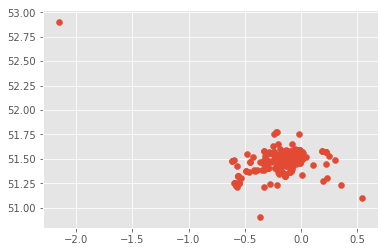

In [15]:
plt.scatter(events['lng'], events['lat'])

In [16]:
subset = events[events['lat']<52]

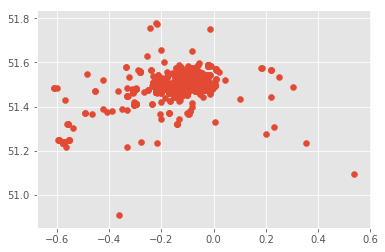

In [17]:
plt.scatter(subset['lng'], subset['lat'])

In [18]:
subset = subset[subset['lat']>51.2]

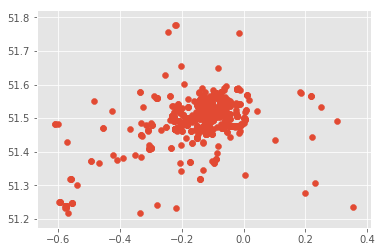

In [19]:
plt.scatter(subset['lng'], subset['lat'])

In [20]:
def SCANING_DB(eps_var = 0.1 , min_sample_var = 5, db = subset, lat_var = 'lat', lng_var = 'lng'):
    dbscan = DBSCAN(eps=eps_var, min_samples = min_sample_var)
#     print(dbscan) 
    arrey_coords = db[[lat_var, lng_var]].values
    #print(arrey_coords)
    #try clustering out on the whole dataset
    dbscan_result = dbscan.fit(arrey_coords)
    dbscan_result_lbls = dbscan_result.labels_
    return(dbscan_result_lbls)
    
    

105
cluster
-1      454
 0       56
 16      51
 45      45
 15      44
 28      41
 42      41
 21      33
 39      33
 44      32
 20      32
 3       31
 22      26
 7       26
 25      23
 10      22
 9       22
 32      21
 43      21
 62      20
 14      20
 60      20
 58      19
 46      18
 52      18
 8       17
 18      17
 2       16
 19      16
 59      15
 35      15
 70      15
 55      14
 33      14
 30      14
 96      14
 11      14
 81      13
 26      13
 17      12
 13      12
 4       12
 6       12
 40      12
 93      11
 86      11
 27      11
 94      11
 37      11
 36      11
 31      11
 73      11
 49      11
 66      11
 56      11
 41      10
 1       10
 65      10
 63      10
 74      10
 77      10
 80      10
 57      10
 91      10
 48      10
 78       9
 75       9
 64       9
 47       9
 88       8
 24       8
 50       8
 12       7
 29       7
 51       7
 99       7
 53       7
 101      7
 68       7
 98       7
 83       6
 87       6
 95 

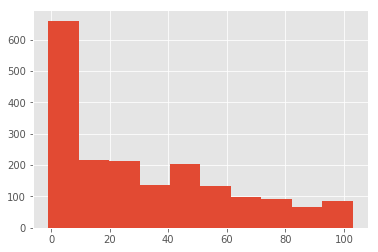

In [21]:
fitted = SCANING_DB(eps_var = 0.001)
subset['cluster'] = fitted
print(len(subset['cluster'].unique()))
print(subset.groupby('cluster').count()['_id'].sort_values(ascending = False))
subset['cluster'].hist()

In [ ]:
fitted = SCANING_DB(eps_var = 0.01)
subset['cluster'] = fitted
print(len(subset['cluster'].unique()))
print(subset.groupby('cluster').count()['_id'].sort_values(ascending = False))
subset['cluster'].hist()

In [ ]:
fitted = SCANING_DB(eps_var = 0.025)
subset['cluster'] = fitted
print(len(subset['cluster'].unique()))
print(subset.groupby('cluster').count()['_id'].sort_values(ascending = False))
subset['cluster'].hist()

In [ ]:
fitted = SCANING_DB(eps_var = 0.06)
subset['cluster'] = fitted
print(len(subset['cluster'].unique()))
print(subset.groupby('cluster').count()['_id'].sort_values(ascending = False))
subset['cluster'].hist()

# Convert to BNG

In [22]:
#need to translate from wgs to bng to do spatial clustering
import pyproj

In [23]:
#to do clustering locations need to be in BNG so that distances are in metres
#Define projections using EPSG codes
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by songkick
osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum, for locations in eastings/northings/metres

#create a new pd without NaNs
londonEventsdfNoNan = subset[subset['lat'].notnull()]

#make new columns for the new latlng
londonEventsdfNoNan['BNGnorthing'] = ""
londonEventsdfNoNan['BNGeasting'] = ""

#reset the index - londonEventsdfNoNan now main dataframe
londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [24]:
#run through the dataset and transform those coordinates
origLat = []
origLng = []

for i in range(0,len(londonEventsdfNoNan)):
    # print(i)
    try:
        origLat.append(londonEventsdfNoNan['lat'][i])
        origLng.append(londonEventsdfNoNan['lng'][i])
        
    except:
        origLat.append(np.nan)
        origLng.append(np.nan)

In [25]:
lat,lon = pyproj.transform(wgs84,osgb36,origLng,origLat)
    
londonEventsdfNoNan['BNGeasting'] = lat
londonEventsdfNoNan['BNGnorthing'] = lon

In [26]:
#now convert from object to numeric
londonEventsdfNoNan['BNGnorthing'] = pd.to_numeric(londonEventsdfNoNan['BNGnorthing'])
londonEventsdfNoNan['BNGeasting'] = pd.to_numeric(londonEventsdfNoNan['BNGeasting'])

In [27]:
londonEventsdfNoNan

,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,location,...,time,type,url,venue,date_name,lat,lng,cluster,BNGnorthing,BNGeasting
0,0,5af9c6dc0cc9ab0004e227d1,[{'mbid': ['aca5718f-4f49-4439-b8f6-209db3f117...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4ac518e9f964a520daab20e3', 'name': 'Ro...",31245569,"{'listeners': [412072, 57, 192843], 'listeners...","{'lng': -0.1491962, 'lat': 51.5429551}",...,19:00:00,Concert,http://www.songkick.com/concerts/31245569-fran...,"{'id': 17874, 'name': 'Roundhouse', 'location'...",Monday,51.5430,-0.1492,0,"184,296.1993","528,443.9440"
1,1,5af9c6de0cc9ab0004e227d3,"[{'mbid': [], 'id': 8437833, 'name': 'Andy May...",2018-05-14,NaT,None,"{'id': '4ac518c5f964a520afa420e3', 'name': 'Th...",31640764,"{'listeners': [18], 'listeners_sum': 18, 'play...","{'lng': -0.1011681, 'lat': 51.5233496}",...,None,Concert,http://www.songkick.com/concerts/31640764-andy...,"{'id': 6950, 'name': 'The Slaughtered Lamb', '...",Monday,51.5233,-0.1012,1,"182,201.3522","531,830.8516"
2,2,5af9c6e30cc9ab0004e227d6,[{'mbid': ['6655955b-1c1e-4bcb-84e4-81bcd9efab...,2018-05-14,2018-05-14 17:45:00,2018-05-14T18:45:00+0100,"{'id': '4ac518e8f964a52075ab20e3', 'name': 'Ro...",31785344,"{'listeners': [721424, 19477], 'listeners_sum'...","{'lng': -0.1781517, 'lat': 51.500786}",...,18:45:00,Concert,http://www.songkick.com/concerts/31785344-olaf...,"{'id': 17538, 'name': 'Royal Albert Hall', 'lo...",Monday,51.5008,-0.1782,2,"179,556.4100","526,552.8784"
3,3,5af9c6e50cc9ab0004e227d8,[{'mbid': ['d100e4ac-31f1-4af1-b0e1-f07c545abb...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32044684,"{'listeners': [313], 'listeners_sum': 313, 'pl...","{'lng': -0.1038429, 'lat': 51.5466983}",...,19:00:00,Concert,http://www.songkick.com/concerts/32044684-elep...,"{'id': 434301, 'name': 'Thousand Island (forme...",Monday,51.5467,-0.1038,3,"184,792.9986","531,578.0036"
4,4,5af9c6eb0cc9ab0004e227db,[{'mbid': ['366323f3-0409-4a30-a3e9-ce1e25d277...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4b5e0cfdf964a520037b29e3', 'name': 'Bu...",32192284,"{'listeners': [7057, 3625], 'listeners_sum': 1...","{'lng': -0.2314873, 'lat': 51.5062847}",...,19:30:00,Concert,http://www.songkick.com/concerts/32192284-gary...,"{'id': 17541, 'name': 'Bush Hall', 'location':...",Monday,51.5063,-0.2315,4,"180,077.1048","522,836.2963"
5,5,5af9c6ed0cc9ab0004e227dd,[{'mbid': ['a1ef6bc8-2644-4b6d-aa21-27b630acf7...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,{},32454499,"{'listeners': [113695], 'listeners_sum': 11369...","{'lng': -0.5541293, 'lat': 51.2486437}",...,19:30:00,Concert,http://www.songkick.com/concerts/32454499-nils...,"{'id': 1262471, 'name': 'G Live', 'location': ...",Monday,51.2486,-0.5541,5,"150,934.1232","501,010.1269"
6,6,5af9c6ef0cc9ab0004e227df,[{'mbid': ['c1982570-8efb-4cf7-bb5b-c9c026c0e8...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '59bbad4dfebf314eba5d9fbb', 'name': 'Br...",32492684,"{'listeners': [120157], 'listeners_sum': 12015...","{'lng': -0.0774607, 'lat': 51.5033289}",...,19:00:00,Concert,http://www.songkick.com/concerts/32492684-lady...,"{'id': 3565864, 'name': 'Bridge Theatre', 'loc...",Monday,51.5033,-0.0775,-1,"180,017.9391","533,533.9375"
7,7,5af9c6f00cc9ab0004e227e1,"[{'mbid': [], 'id': 6651674, 'name': 'Gemma Kh...",2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53aa2db3498e191dfd67bd05', 'name': 'Fo...",32649974,"{'listeners': [32], 'listeners_sum': 32, 'play...","{'lng': -0.1355174, 'lat': 51.5403054}",...,19:00:00,Concert,http://www.songkick.com/concerts/32649974-gemm...,"{'id': 2683308, 'name': 'Folk in the Cellar: T...",Monday,51.5403,-0.1355,-1,"184,025.6281","529,399.9595"
8,8,5af9c6f40cc9ab0004e227e4,[{'mbid': ['8af55e27-c6ad-44f3-a6d2-53df546279...,2018-05-14,2018-05-14 19:00:00,2018-05-14T20:00:00+0100,"{'id': '4acdbaf0f964a520d6cc20e3', 'name': 'Ki...",32754149,

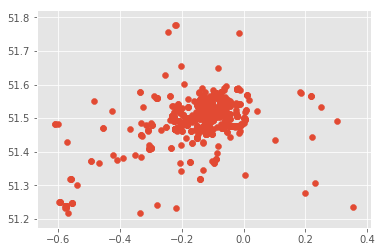

In [28]:
plt.scatter(londonEventsdfNoNan['lng'], londonEventsdfNoNan['lat'])

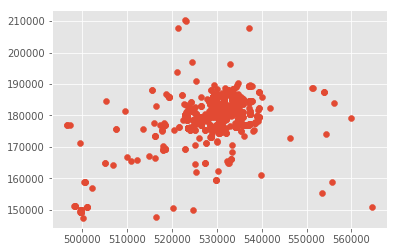

In [29]:
plt.scatter(londonEventsdfNoNan['BNGeasting'], londonEventsdfNoNan['BNGnorthing'])

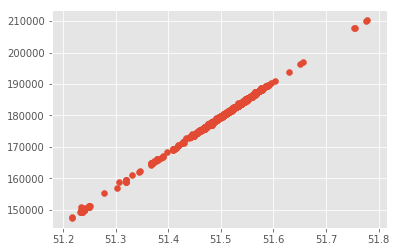

In [30]:
plt.scatter(londonEventsdfNoNan['lat'], londonEventsdfNoNan['BNGnorthing'])

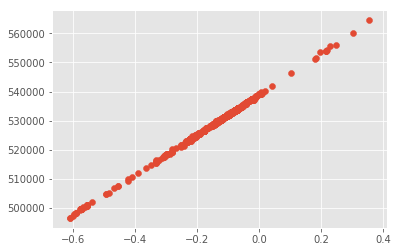

In [31]:
plt.scatter(londonEventsdfNoNan['lng'], londonEventsdfNoNan['BNGeasting'])

In [ ]:
fitted = SCANING_DB(eps_var = 750, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', db = londonEventsdfNoNan)
londonEventsdfNoNan['cluster'] = fitted
print(len(londonEventsdfNoNan['cluster'].unique()))
print(londonEventsdfNoNan.groupby('cluster').count()['_id'].sort_values(ascending = False))
londonEventsdfNoNan['cluster'].hist()

In [32]:
# Make a function to subset the genre depending on which dataset
def subset_by_genre(db, lib = 'spotify', words = 'reggae'):
    return db[db[lib].astype(str).str.contains(words, case=False)]

#create a genre compiling function
def genre_df_compiler(genreName, db = londonEventsdfNoNan):
    firstEventsdf = subset_by_genre(db, lib='spotify',words = genreName)
    secondEventsdf = subset_by_genre(db, lib='lastfm',words = genreName)
    allEventsdf = "all"+genreName+"Events" 
    allEventsdf = pd.concat([firstEventsdf, secondEventsdf])
    allEventsdf = allEventsdf.drop_duplicates(subset='_id', keep='last')
    return(allEventsdf)

In [33]:
jazz =  genre_df_compiler('jazz', db = londonEventsdfNoNan)
jazz.reset_index(inplace = True)

In [34]:
jazz

,level_0,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,...,time,type,url,venue,date_name,lat,lng,cluster,BNGnorthing,BNGeasting
0,20,20,5af9c7130cc9ab0004e227ff,"[{'mbid': [], 'id': 5581788, 'name': 'Tony Mal...",2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4b08016df964a520320223e3', 'name': 'Vo...",33428984,"{'listeners': [7], 'listeners_sum': 7, 'playco...",...,19:00:00,Concert,http://www.songkick.com/concerts/33428984-tony...,"{'id': 7012, 'name': 'Vortex Jazz Club', 'loca...",Monday,51.5487,-0.0765,15,"185,066.0063","533,468.0048"
1,151,151,5afab9c5dcab560004a0af71,[{'mbid': ['7c3626b0-5f9d-4415-9a9d-f8770f4d6b...,2018-05-16,2018-05-16 18:00:00,2018-05-16T19:00:00+0100,"{'id': '5807d81f38fa0c5319eb08df', 'name': 'Om...",33683804,"{'listeners': [3466, 15630, 13448], 'listeners...",...,19:00:00,Concert,http://www.songkick.com/concerts/33683804-joel...,"{'id': 3375829, 'name': 'Omeara', 'location': ...",Wednesday,51.5041,-0.0946,14,"180,077.3475","532,341.8876"
2,172,172,5afaba02dcab560004a0afa4,[{'mbid': ['85e65d5f-4d9b-407d-b261-882caa52bf...,2018-05-17,2018-05-17 18:00:00,2018-05-17T19:00:00+0100,"{'id': '4bc76e872f94d13a36ea117f', 'name': 'O2...",32168414,"{'listeners': [85166, 183], 'listeners_sum': 8...",...,19:00:00,Concert,http://www.songkick.com/concerts/32168414-prem...,"{'id': 38323, 'name': 'O2 Academy Islington', ...",Thursday,51.5346,-0.1059,21,"183,442.0679","531,468.8547"
3,199,199,5afaba4cdcab560004a0afe5,"[{'mbid': [], 'id': 8948809, 'name': 'PFM Prem...",2018-05-17,2018-05-17 17:30:00,2018-05-17T18:30:00+0100,"{'id': '4bc76e872f94d13a36ea117f', 'name': 'O2...",33217009,"{'listeners': [85166], 'listeners_sum': 85166,...",...,18:30:00,Concert,http://www.songkick.com/concerts/33217009-pfm-...,"{'id': 1064401, 'name': 'O2 Academy 2 Islingto...",Thursday,51.5346,-0.1059,21,"183,442.0679","531,468.8547"
4,271,272,5afabb26dcab560004a0b099,[{'mbid': ['0fc04d4a-e795-49b3-814b-02f7517666...,2018-05-18,2018-05-18 22:00:00,2018-05-18T23:00:00+0100,"{'id': '4ac518c9f964a52094a520e3', 'name': 'Fa...",32868499,"{'listeners': [50751, 59086, 2451, 43251, 1183...",...,23:00:00,Concert,http://www.songkick.com/concerts/32868499-art-...,"{'id': 8850, 'name': 'fabric', 'location': {'l...",Friday,51.5196,-0.1025,35,"181,776.8118","531,750.9378"
5,299,300,5afabb8ddcab560004a0b0ee,[{'mbid': ['00f29491-a87d-47d4-abd8-8c49067a48...,2018-05-18,NaT,None,"{'id': '529914c5498ee1d13944a93b', 'name': 'Th...",33506839,"{'listeners': [176], 'listeners_sum': 176, 'pl...",...,None,Concert,http://www.songkick.com/concerts/33506839-jazz...,"{'id': 3279, 'name': 'The Crypt', 'location': ...",Friday,51.4736,-0.0872,-1,"176,689.8663","532,946.3022"
6,391,392,5afabd0edcab560004a0b20b,[{'mbid': ['ab102e9a-1fde-4694-8367-6ec68a312f...,2018-05-19,2018-05-19 18:00:00,2018-05-19T19:00:00+0100,"{'id': '4ac518ebf964a52041ac20e3', 'name': 'Vi...",33466534,"{'listeners': [9845], 'listeners_sum': 9845, '...",...,19:00:00,Concert,http://www.songkick.com/concerts/33466534-izem...,"{'id': 628031, 'name': 'Village Underground', ...",Saturday,51.5238,-0.0780,96,"182,291.9710","533,434.4336"
7,758,759,5afaee7df4259d0004b0e619,[{'mbid': ['5ce64ed9-3015-4910-a2bb-1cd5c933de...,2018-04-15,2018-04-15 18:30:00,2018-04-15T19:30:00+0100,NaN,30576499,"{'listeners': [93219], 'listeners_sum': 93219,...",...,19:30:00,Concert,http://www.songkick.com/concerts/30576499-sonn...,"{'id': 30247, 'name': '229', 'location': {'lng...",Sunday,51.5235,-0.1442,77,"182,137.4000","528,841.9670"
8,897,898,5afaefe7f4259d0004b0e765,[{'mbid': ['812c46e5-3d65-4e80-ada8-269450c562...,2018-04-18,2018-04-18 22:00:00,2018-04-18T23:00:00+0100,NaN,32536464,"{'listeners': [80793], 'listeners_sum': 80793,...",...,23:00:00,Concert,http://www.songkick.com/concerts/32536464-jord...,"{'id': 36418, 'name': 'Ronnie Scott's', 'locat...",Wednesday,51.5135,-0.1315,44,"181,051.7064","529,753.3538"
9,916,917,5afaf027f4259d0004b0e798,[{'mbid': ['62dc94cc-f611-4345-87cb-b91

# Test jazz

10
cluster
-1    59
 4    22
 1    20
 0    18
 5    17
 3    15
 7    10
 2     7
 6     6
 8     5
Name: _id, dtype: int64


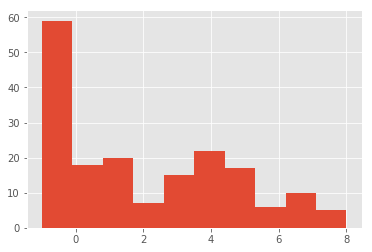

In [43]:
fitted = SCANING_DB(eps_var = 750, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', db = jazz)
jazz['cluster'] = fitted
print(len(jazz['cluster'].unique()))
print(jazz.groupby('cluster').count()['_id'].sort_values(ascending = False))
jazz['cluster'].hist()

In [44]:
#create dataframe for storing the clusternos per eps value
clusterNoEps = pd.DataFrame()

In [48]:
def eps_df_genre(db = jazz, epsMin = 1, epsMax = 2000, epsStep = 10, colName = "ClusterNosjazz"):
    clusterNos = []
    epsValues = list(range(epsMin, epsMax, epsStep))
    epsDF = pd.DataFrame(epsValues)
    for i in epsValues:
        fitted = SCANING_DB(eps_var = i, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', db = db)
        db['cluster'] = fitted
        clusterNos.append(len(db['cluster'].unique()))
    epsDF[colName] = pd.DataFrame(clusterNos)
    return epsDF

In [46]:
clusterNos

NameError: name 'clusterNos' is not defined

In [49]:
epsDFjazz = eps_df_genre(db = jazz, colName = "ClusterNosjazz")


In [42]:
epsDFevents = eps_df_genre(db = londonEventsdfNoNan, colName = "ClusterNosevents")

TypeError: Index(...) must be called with a collection of some kind, 'ClusterNos' was passed

In [ ]:
epsDFjazz

In [ ]:
folk =  genre_df_compiler('folk', db = londonEventsdfNoNan)
folk.reset_index(inplace = True)
epsDFfolk = eps_df_genre(db = folk, colName = "ClusterNosfolk")

In [ ]:
indie =  genre_df_compiler('indie', db = londonEventsdfNoNan)
indie.reset_index(inplace = True)
epsDFindie = eps_df_genre(db = indie, colName = "ClusterNosindie")

In [ ]:
classical =  genre_df_compiler('classical', db = londonEventsdfNoNan)
classical.reset_index(inplace = True)
epsDFclassical = eps_df_genre(db = classical, colName = "ClusterNosclassical")

In [ ]:
house =  genre_df_compiler('house', db = londonEventsdfNoNan)
house.reset_index(inplace = True)
epsDFhouse = eps_df_genre(db = house, colName = "ClusterNoshouse")

In [ ]:
rock =  genre_df_compiler('rock', db = londonEventsdfNoNan)
rock.reset_index(inplace = True)
epsDFrock = eps_df_genre(db = rock, colName = "ClusterNosrock")

In [ ]:
reggae =  genre_df_compiler('rock', db = londonEventsdfNoNan)
reggae.reset_index(inplace = True)
epsDFreggae = eps_df_genre(db = reggae, colName = "ClusterNosreggae")

In [ ]:
grime =  genre_df_compiler('grime', db = londonEventsdfNoNan)
grime.reset_index(inplace = True)
epsDFgrime = eps_df_genre(db = grime, colName = "ClusterNosgrime")

In [ ]:
epsDFall = pd.concat([epsDFevents, epsDFjazz, epsDFfolk, epsDFclassical, epsDFgrime, epsDFreggae, epsDFrock, epsDFhouse, epsDFindie], axis=1, join_axes=[epsDFevents[0]])

In [ ]:
epsDFall

In [ ]:
epsDFall = epsDFall.loc[:,~epsDFall.columns.duplicated()]

In [ ]:
epsDFall.columns

In [ ]:
trace0 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosevents'], 
                    name = 'All Events', 
                    line = dict(color = ('rgb(205, 12, 24)'), width = 4))
trace1 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosjazz'], 
                    name = 'Jazz Events', 
                    line = dict(color = ('rgb(22, 96, 167)'), width = 4))
trace2 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosfolk'], 
                    name = 'Folk Events', 
                    line = dict(color = ('rgb(100, 12, 24)'), width = 4))
trace3 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosclassical'], 
                    name = 'Classical Events', 
                    line = dict(color = ('rgb(150, 96, 167)'), width = 4))
trace4 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosgrime'], 
                    name = 'Grime Events', 
                    line = dict(color = ('rgb(70, 96, 167)'), width = 4))
trace5 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosreggae'], 
                    name = 'Reggae Events', 
                    line = dict(color = ('rgb(175, 96, 167)'), width = 4))
trace6 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosrock'], 
                    name = 'Rock Events', 
                    line = dict(color = ('rgb(255, 96, 167)'), width = 4))
trace7 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNoshouse'], 
                    name = 'House Events', 
                    line = dict(color = ('rgb(0, 96, 167)'), width = 4))
trace8 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosindie'], 
                    name = 'Indie Events', 
                    line = dict(color = ('rgb(70, 96, 100)'), width = 4))

graphData = [
#             trace0, 
             trace1, 
             trace2, 
             trace3, 
             trace4,
             trace5,
             trace6,
             trace7,
             trace8]

# Edit the layout
layout = dict(title = 'No. Clusters at EPS values',
              xaxis = dict(title = 'EPS Value'),
              yaxis = dict(title = 'No. Clusters'),
              )

fig = dict(data=graphData, layout=layout)
py.iplot(fig, filename='styled-line')

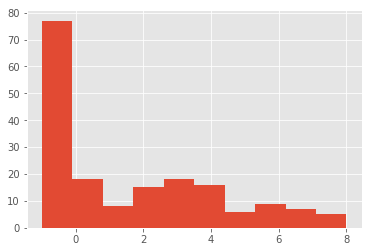

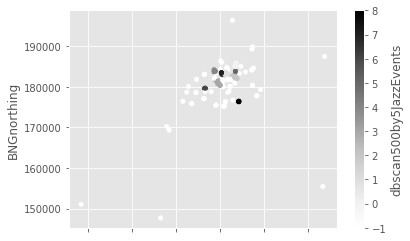

In [51]:
#now get folium map of clusters
#need to create the function to add labels of clusters to the dataframe
#eps 500 minsamples 5
# def SCANING_DB(eps_var = 0.1 , min_sample_var = 5, db = subset, lat_var = 'lat', lng_var = 'lng'):
#     dbscan = DBSCAN(eps=eps_var, min_samples = min_sample_var)
#     print(dbscan) 
#     arrey_coords = db[[lat_var, lng_var]].values
    #print(arrey_coords)
# try clustering out on the whole dataset
#     dbscan_result = dbscan.fit(arrey_coords)
#     dbscan_result_lbls = dbscan_result.labels_
#     return(dbscan_result_lbls)

dbscanJazzLabels = SCANING_DB(eps_var = 500, db = jazz, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

jazz['dbscan500by5JazzEvents'] = pd.DataFrame(dbscanJazzLabels)

jazz['dbscan500by5JazzEvents'].hist()

jazz.plot.scatter(y='BNGnorthing', x='BNGeasting', c='dbscan500by5JazzEvents')

In [52]:
#find the different labels inside the db
jazz.dbscan500by5JazzEvents.unique()

array([ 0, -1,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

In [ ]:
#possible colors
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black']


In [53]:
#new jazz list
#trying out a map of this clustering
#create a map with our data in center
latList = jazz['lat'].tolist()
lngList = jazz['lng'].tolist()
clusterLabelList = jazz['dbscan500by5JazzEvents'].tolist()
medLat = jazz['lat'].median()
medLng = jazz['lng'].median()

this_map = folium.Map([medLat, medLng], zoom_start=12, tiles="Cartodb Positron", control_scale=True)




for lat, lng, label in zip(latList, lngList, clusterLabelList):
    if label == -1:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='gray', fill_color='orange', fill_opacity=0.7))
    elif label == 0:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='blue', fill_color='orange', fill_opacity=0.7))
    elif label == 1:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='lightred', fill_color='orange', fill_opacity=0.7))
    elif label == 2:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='yellow', fill_color='orange', fill_opacity=0.7))
    elif label == 3:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='lightgreen', fill_color='orange', fill_opacity=0.7))
    elif label == 4:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='orange', fill_color='orange', fill_opacity=0.7))
    elif label == 5:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='purple', fill_color='orange', fill_opacity=0.7))
    elif label == 6:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='pink', fill_color='orange', fill_opacity=0.7))
    elif label == 7:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='lightblue', fill_color='orange', fill_opacity=0.7))
    elif label == 8:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='black', fill_color='orange', fill_opacity=0.7))
    elif label == 9:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='darkred', fill_color='orange', fill_opacity=0.7))
    elif label == 10:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='beige', fill_color='orange', fill_opacity=0.7))
    elif label == 11:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='cadetblue', fill_color='orange', fill_opacity=0.7))
    elif label == 12:
        this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 5, color='darkgreen', fill_color='orange', fill_opacity=0.7))
    
    else:
        pass


In [54]:
this_map